In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import geopandas
from scipy.ndimage import binary_erosion
from skimage.measure import approximate_polygon, find_contours
import shapely
import imantics

annotation_file = "C:/Users/jcc234/OneDrive - University of Exeter/Documents/Projects/Bec/Islet expansion python/QuPath proj/Example with doughnut annotation.geojson" 
g_df=geopandas.read_file(annotation_file)


In [5]:
shell_coords=shapely.get_coordinates(g_df.geometry[0])

hole_coords=shapely.get_coordinates(g_df.geometry[2])

new_poly=shapely.Polygon(shell=shell_coords, holes=[hole_coords])

In [6]:
g_df.at[3,"geometry"]=new_poly
g_df.at[3,"objectType"]="annotation"
g_df.at[3,"classification"]={"name":"doughnut", "color": [0, 0, 100]}

In [ ]:
#Save new geojson
from geojson import dump #Point, Feature, FeatureCollection, 

# Set the location of the geojson annotation file to be used (NB. new files will be saved to the same location with modified names)
new_path=annotation_file.replace(".geojson", "_doughnut.geojson")

with open(new_path, 'w') as f:
   dump(g_df, f)

## Making annotations with holes in

Initial examples are: 
1. Tissue with multiple annotated holes
2. Rings around annotated individual annotated islets

In [7]:
# Using separate annotation files e.g. expanded and original islets where one is within the other
expanded_annotation="P:/Bec DT/QuPath/315_89_MSC Panel and Hormone Panel_SerialStainFuse_2024501051inc tissue_expanded_200.geojson"
original_annotation="P:/Bec DT/QuPath/315_89_MSC Panel and Hormone Panel_SerialStainFuse_2024501051inc tissue.geojson"

expanded_g_df=geopandas.read_file(expanded_annotation)
original_g_df=g_df=geopandas.read_file(original_annotation)



DriverError: P:/Bec DT/QuPath/315_89_MSC Panel and Hormone Panel_SerialStainFuse_2024501051inc tissue_expanded_200.geojson: No such file or directory

In [10]:
#Extract the classification names to a new col
classifications_original=g_df["classification"]
original_g_df["names"]=[obj["name"] for obj in classifications_original] #extract annotation names

classifications_expanded=g_df["classification"]
expanded_g_df["names"]=[obj["name"] for obj in classifications_expanded] #extract annotation names


NameError: name 'original_g_df' is not defined

In [ ]:
original_g_df.geometry[1].within(expanded_g_df.geometry).sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0      False
1      False
2      False
3      False
4      False
       ...  
333    False
334    False
335    False
336    False
337    False
Name: geometry, Length: 338, dtype: bool>

In [ ]:
expanded_g_df[original_g_df.geometry.within(expanded_g_df.geometry)]

,id,object_type,classification,isLocked,names,geometry
228,228,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (12681.00000 2839.00000, 12681.0000..."
229,229,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (13803.00000 3795.00000, 13803.0000..."
230,230,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (14418.00000 4754.00000, 14408.0000..."
231,231,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (14259.00000 4794.00000, 14249.0000..."
232,232,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (14378.00000 4774.00000, 14368.0000..."
...,...,...,...,...,...,...
333,333,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (13463.00000 18155.00000, 13473.000..."
334,334,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (6621.00000 31557.00000, 6611.00000..."
335,335,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (12103.00000 31875.00000, 12103.000..."
336,336,annotation,"{'name': 'Acinar+Islets_inside mapped tissue',...",False,Acinar+Islets_inside mapped tissue,"LINESTRING (12580.00000 4743.00000, 12580.0000..."


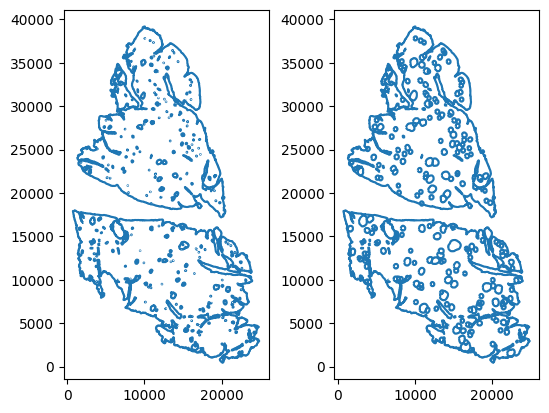

In [ ]:
fig, axs = plt.subplots(1,2)

original_g_df.plot(ax=axs[0])

expanded_g_df.plot(ax=axs[1])

plt.show()

In [ ]:
original_test_islet_coords=shapely.get_coordinates(original_g_df.geometry[0])
expanded_test_islet_coords=shapely.get_coordinates(expanded_g_df.geometry[0])

test_expanded_poly=shapely.Polygon(expanded_test_islet_coords)
test_original_poly=shapely.Polygon(original_test_islet_coords)

test_original_poly.within(test_expanded_poly)


##This shows that the shapes need to be polygons for them to be considered "within" each other, rather than linestrings
#This is OK in QuPath (I think), but is that true in Halo?

True

In [8]:
## Function to make all the annotations into polygons from linestrings. Putthing these into a new column in the df and outputting this

def add_poly_col(g_df):

    for i in range(len(g_df)):
        line_coords=shapely.get_coordinates(g_df.iloc[i]["geometry"])#get coordinates of the linestring shape
        g_df.at[i,"poly_shape"]=shapely.Polygon(line_coords)#make the line into a polygon. Save that to a new column for that row in thhe df

    return g_df

In [9]:
# add the polygon columns to the geo dfs
original_g_df=add_poly_col(original_g_df)
expanded_g_df=add_poly_col(expanded_g_df)


NameError: name 'original_g_df' is not defined

## Are polygons within other shapes?

In [ ]:
#Make dfs of only expanded islets or tissue
Islets_only_expanded_df=expanded_g_df[((expanded_g_df["names"]=="IDI") | (expanded_g_df["names"]=="ICI"))].copy()
Tissue_only=original_g_df[original_g_df["names"]=='Acinar+Islets_inside mapped tissue'].copy()



In [ ]:
# Loop through annotations. If they're within another, add them to a list which can ultimately be made into the holes of a polygon
row_index_list=Tissue_only.index

Tissue_only["status"]="orphan"#make all anotations orphas to begin with, then assign parent child status as processed. 
processed_tissue=pd.DataFrame(columns=Tissue_only.columns)#new df for the processed annotations

for row_num in row_index_list:

    row = Tissue_only.loc[row_num].copy() # pull out the row
    contained_mask=Tissue_only.loc[row_num,"poly_shape"].contains(Tissue_only["poly_shape"]) # get mask for df of all the tissue annotations within this annotation
    contained_mask.at[row_num] = False # remove self from the match list
    tissue_holes=Tissue_only[contained_mask]["poly_shape"].tolist() # make a list of the polygons of the annotations
    Tissue_only.loc[contained_mask,"status"]="child"

    if (len(tissue_holes)>0): # If some anotations are found within the annotation being checked then do this

        Tissue_only.loc[row_num,"status"]="parent" # change status 

        shell_coords=shapely.get_coordinates(row["poly_shape"]) # get the coordinates of the annotation in the original row
        holes_coords=[shapely.get_coordinates(i) for i in tissue_holes] # get coordinates of all the annotations contained 
        final_poly=shapely.Polygon(shell = shell_coords, holes=holes_coords) # make a new polygon with holes for the contained annotations

        row["poly_shape"]=final_poly # replace the original annotation polygon with a new one containing holes
        row_df=pd.DataFrame([row])
        processed_tissue=pd.concat([processed_tissue,row_df]) # add to a the new df

        print("Row "+str(row_num) + "contains"+str(contained_mask.sum())) # print a message detailing the holes found


#Add any remaining orphan annotations to the new df with parent polygons
orphan_df=Tissue_only[Tissue_only["status"]=="orphan"]
if len(orphan_df)>0:
    processed_tissue=pd.concat([processed_tissue,orphan_df]) # add to a the new df

# Make the df into a geopandas df




Row 333contains48
Row 337contains60


C:\Users\jcc234\AppData\Local\Temp\ipykernel_23836\4259034840.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_tissue=pd.concat([processed_tissue,row_df]) # add to a the new df


In [4]:
# processed_tissue=processed_tissue.drop(columns=["status", "names", "geometry"]).rename(columns={"poly_shape":"geometry"})
processed_tissue


NameError: name 'processed_tissue' is not defined

In [281]:
geopandas.GeoDataFrame(processed_tissue, geometry="geometry")


TypeError: 'list' object is not callable

In [283]:
df = pd.DataFrame(
    {
        "City": ["Buenos Aires", "Brasilia", "Santiago", "Bogota", "Caracas"],
        "Country": ["Argentina", "Brazil", "Chile", "Colombia", "Venezuela"],
        "Latitude": [-34.58, -15.78, -33.45, 4.60, 10.48],
        "Longitude": [-58.66, -47.91, -70.66, -74.08, -66.86],
    }
)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)

TypeError: 'list' object is not callable